# Линейная регрессия

In [1]:
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [2]:
D = np.loadtxt('../data/lin_reg.txt', delimiter=',')

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [3]:
def get_cv_folds(X, cv):
    indices = np.random.permutation(X.shape[0])
    fold_length = X.shape[0] // cv

    folds = []
    for fold_n in range(cv):
        fold_idx = indices[fold_n * fold_length: (fold_n + 1) * fold_length]
        fold = X[fold_idx, :]
        folds.append(fold)

    return np.array(folds)


def prepare(data):
    X, y = data[:, :-1], data[:, -1]

    # add intercept column
    X = np.append(X, np.array([[1] * X.shape[0]]).T, axis=1)

    X = X.astype(np.float32)
    y = y.astype(np.float32)

    X = Variable(torch.from_numpy(X).cuda())
    y = Variable(torch.from_numpy(y).cuda())
    
    y = y.reshape((y.shape[0], 1))

    return X, y

In [4]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, X):
        out = self.linear(X)
        return out


def reg_mse(model, y_pred, y_true, alpha):
    '''MSE with L2-regulatization'''
    criterion = nn.MSELoss().cuda()

    loss = criterion(y_pred, y_true)
    loss += sum([
        alpha * torch.norm(param)
        for param in model.parameters()
    ])
    return loss


def iterate(model, X_train, y_train, X_val, y_val, alpha):
    '''Go through one train epoch and return losses'''
    loss = reg_mse(model, y_train, model(X_train), alpha)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss = reg_mse(model, y_train, model(X_train), alpha)
    val_loss = reg_mse(model, y_val, model(X_val), alpha)

    return train_loss, val_loss

alpha 0.001, loss 98.95825958251953
alpha 0.01, loss 98.70037078857422
alpha 0.1, loss 99.99295806884766
alpha 1.0, loss 107.8177490234375


[]

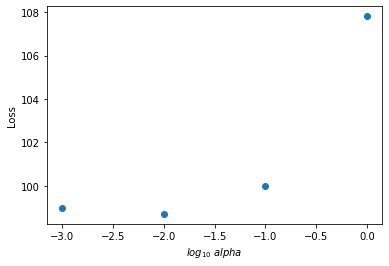

In [5]:
input_dim = 5
output_dim = 1
lr = 0.01 
epochs = 2000
alphas = 10 ** np.arange(-3, 1, dtype=float)

X, y = prepare(D)

losses = {}
for alpha in alphas:
    model = LinearRegression(input_dim, output_dim)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        loss, _ = iterate(model, X, y, X, y, alpha)

    losses[np.log10(alpha)] = loss.item()
    print(f'alpha {alpha}, loss {loss.item()}')

plt.scatter(losses.keys(), losses.values())
plt.xlabel('$log_{10}\;alpha$')
plt.ylabel('Loss')
plt.plot()

fold 0 alpha 0.001, loss 92.99930572509766
fold 0 alpha 0.01, loss 92.91063690185547
fold 0 alpha 0.1, loss 94.24494171142578
fold 0 alpha 1.0, loss 101.80415344238281
fold 1 alpha 0.001, loss 103.13139343261719
fold 1 alpha 0.01, loss 102.28271484375
fold 1 alpha 0.1, loss 104.0198745727539
fold 1 alpha 1.0, loss 111.16828918457031
fold 2 alpha 0.001, loss 101.5322494506836
fold 2 alpha 0.01, loss 101.54930114746094
fold 2 alpha 0.1, loss 101.83201599121094
fold 2 alpha 1.0, loss 109.6402587890625
fold 3 alpha 0.001, loss 106.67762756347656
fold 3 alpha 0.01, loss 105.78760528564453
fold 3 alpha 0.1, loss 106.4411392211914
fold 3 alpha 1.0, loss 113.07595825195312
fold 4 alpha 0.001, loss 99.55300903320312
fold 4 alpha 0.01, loss 100.13573455810547
fold 4 alpha 0.1, loss 101.22218322753906
fold 4 alpha 1.0, loss 107.04371643066406


[]

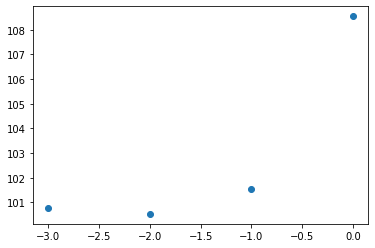

In [6]:
cv = 5
cv_losses = defaultdict(list)

folds = get_cv_folds(D, cv)
for fold_n, fold in enumerate(folds):
    for alpha in alphas:
        X_val, y_val = prepare(fold)

        data_train = np.concatenate(folds[[i for i in range(len(folds)) if i != fold_n]])
        X_train, y_train = prepare(data_train)

        model = LinearRegression(input_dim, output_dim)
        model.cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
            _, loss = iterate(model, X_train, y_train, X_val, y_val, alpha)

        print(f'fold {fold_n} alpha {alpha}, loss {loss.item()}')
        cv_losses[np.log10(alpha)].append(loss.item())

mean_losses = {alpha: np.mean(losses) for alpha, losses in cv_losses.items()}
plt.scatter(mean_losses.keys(), mean_losses.values())
plt.plot()

[]

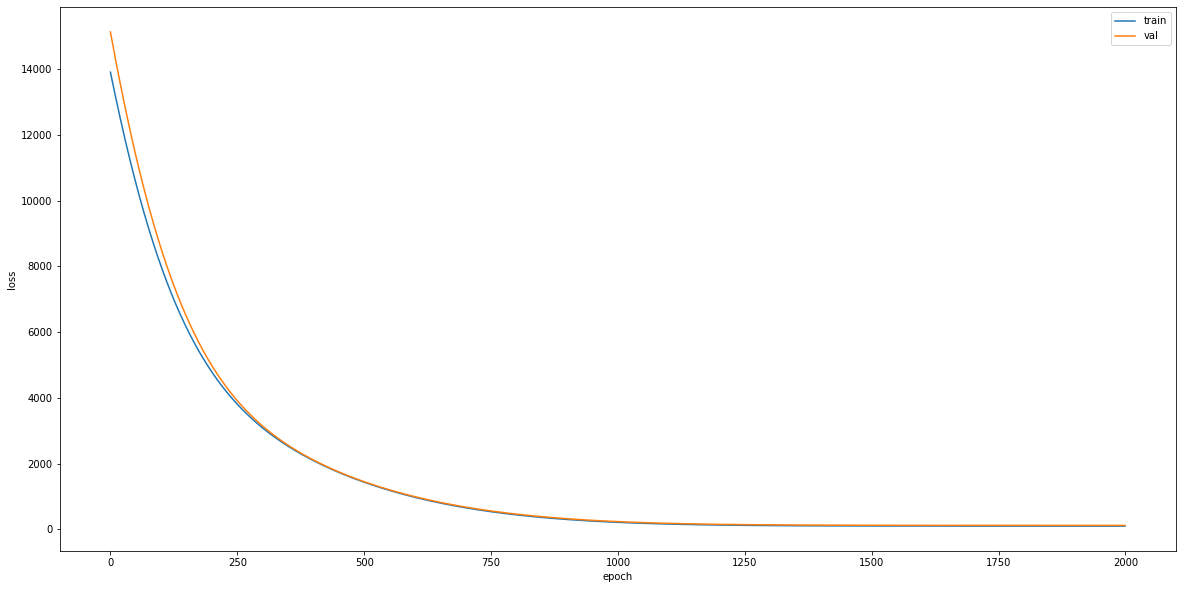

In [7]:
alpha = np.argmin(mean_losses.values())
train_losses = np.zeros((epochs, cv))
val_losses = np.zeros((epochs, cv))

folds = get_cv_folds(D, cv)
for fold_n, fold in enumerate(folds):
    X_val, y_val = prepare(fold)

    data_train = np.concatenate(folds[[i for i in range(len(folds)) if i != fold_n]])
    X_train, y_train = prepare(data_train)

    model = LinearRegression(input_dim, output_dim)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss, val_loss = iterate(model, X_train, y_train, X_val, y_val, alpha)
        train_losses[epoch] = train_loss.item()
        val_losses[epoch] = val_loss.item()

plt.figure(figsize=(20,10))
plt.plot(range(epochs), train_losses.mean(axis=1))
plt.plot(range(epochs), val_losses.mean(axis=1))
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot()